<a href="https://colab.research.google.com/github/Mosesomo/Data_Science/blob/master/AnomaData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values per column:
time    0
y       0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
y.1     0
Length: 62, dtype: int64
Data description:
                  y            x1            x2            x3            x4  \
count  18398.000000  18398.000000  18398.000000  18398.000000  18398.000000   
mean       0.006740      0.011824      0.157986      0.569300     -9.958345   
std        0.081822      0.742875      4.939762      5.937178    131.033712   
min        0.000000     -3.787279    -17.316550    -18.198509   -322.781610   
25%        0.000000     -0.405681     -2.158235     -3.537054   -111.378372   
50%        0.000000      0.128245     -0.075505     -0.190683    -14.881585   
75%        0.000000      0.421222      2.319297      3.421223     92.199134   
max        1.000000      3.054156     16.742105     15.900116    334.694098   

                 x5            x6            x7            x8            x9  \
count  18398.000000  18398.00

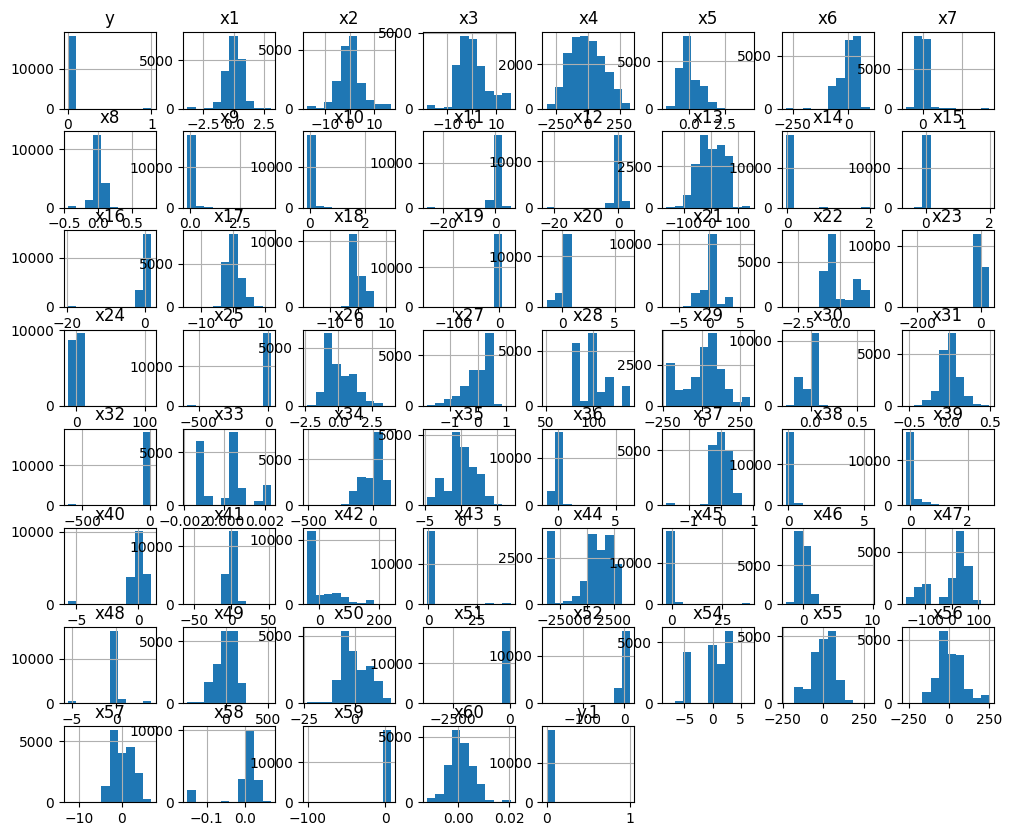

Class distribution in target variable 'y':
y
0    18274
1      124
Name: count, dtype: int64
Training set shape: (5520, 17), Testing set shape: (1381, 17)
Confusion Matrix:
[[1050  323]
 [   5    3]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1373
           1       0.01      0.38      0.02         8

    accuracy                           0.76      1381
   macro avg       0.50      0.57      0.44      1381
weighted avg       0.99      0.76      0.86      1381

ROC-AUC score: 0.6172614712308814


<Figure size 640x480 with 0 Axes>

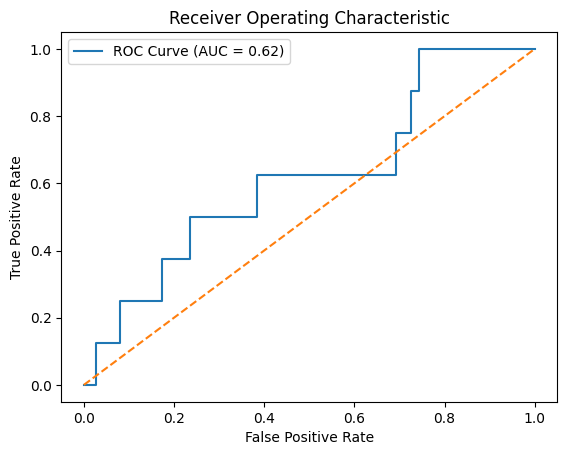

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

# saving to csv
# data = pd.read_excel('AnomaData/data/AnomaData.xlsx', engine='openpyxl')
# data.to_csv('AnomaData/data/AnomaData.csv', index=False)  # Save as CSV

'''Data Loading and Exploration (EDA)'''
# Loading the data
data = pd.read_csv('AnomaData/data/AnomaData.csv')

# Data Quality check (missing values)
print("Missing values per column:")
print(data.isnull().sum())

# Display basic statistics
print("Data description:")
print(data.describe())

# Plot histograms of features
data.hist(figsize=(12, 10))
plt.show()
plt.savefig('AnomaData/visuals/features.png')

# Exploring anomalies in the target variable
print("Class distribution in target variable 'y':")
print(data['y'].value_counts())

''''Data Preprocessing and Model Training'''

# Define features and target variable
X = data[['x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60']]
y = data['y']

# Remove outliers
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
X = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]
y = y[X.index]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


'''Model Training and Tuning'''
# Define SMOTE and RandomUnderSampler
smote = SMOTE(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)

# Create a pipeline with SMOTE and XGBoost
pipeline = Pipeline([
    ('smote', smote),
    ('under_sampler', under_sampler),
    ('xgb', XGBClassifier(random_state=42))
])

# Hyperparameter tuning using RandomizedSearchCV
param_grid = {
    'xgb__n_estimators': [50, 100, 150, 200],
    'xgb__max_depth': [3, 5, 7, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__scale_pos_weight': [1, 5, 10, 20]
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=20, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Getting the best model
best_model = random_search.best_estimator_

'''Model Evaluation and Saving the Model'''
# Predict probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Optimize threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
y_pred_optimal = (y_probs > optimal_threshold).astype(int)

# Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC score: {roc_auc}")

# Saving the model to disk
import pickle
with open('AnomaData/models/best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

'''ROC Curve Visualization'''
# Ploting ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.savefig('AnomaData/visuals/roc_curve.png')
plt.show()
